In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator

In [3]:
np.random.seed(210115941)  

# B1 Data loading and inspection [3 mark]

In [4]:
data_flag = 'breastmnist'
download = True

#use the method in github to download and preprocess the dataset
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

#store the data in './data'
train_dataset = DataClass(root='./data', split='train', transform=data_transform, download=download)
val_dataset = DataClass(root='./data', split='val', transform=data_transform, download=download)
test_dataset = DataClass(root='./data', split='test', transform=data_transform, download=download)


train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Using downloaded and verified file: ./data\breastmnist.npz
Using downloaded and verified file: ./data\breastmnist.npz
Using downloaded and verified file: ./data\breastmnist.npz


In [5]:
#part B

#B1
#def a function to classfiy the data in different label, make it easy for us to plot
def classify(dataset):
    
    images_0=[]
    images_1=[]
    for data in dataset:
        image , label = data
        if label==0:
            images_0.append(image.squeeze().numpy())#transform tensor to array
        else:
            images_1.append(image.squeeze().numpy())#transform tensor to array
    return images_0,images_1

#use the above function to classfiy train, valid and test dataset to 2 classes
image_train_0, image_train_1 = classify(train_dataset)
image_val_0, image_val_1 = classify(val_dataset)
image_test_0, image_test_1 = classify(test_dataset)


In [6]:
#B1
#def a function to plot 20 images in each dataset

def imshow_20(dataset,num):
    plt.figure(figsize=(8,int(num/4)))
    for i in range(num):
        plt.subplot(int(num/5), 5, i + 1)
        plt.imshow(dataset[i], cmap='gray')
        plt.xticks(())
        plt.yticks(())


20 images in train dataset, class=0


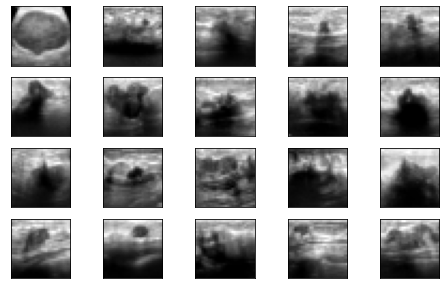

In [7]:
#B1
#plot 20 images in train, class=0
imshow_20(image_train_0,20)
print("20 images in train dataset, class=0")

20 images in train dataset, class=1


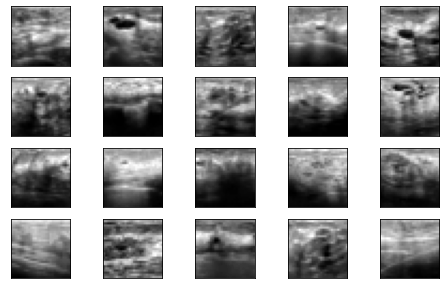

In [8]:
#B1
imshow_20(image_train_1,20)
print("20 images in train dataset, class=1")

10 images in validation dataset, class=0


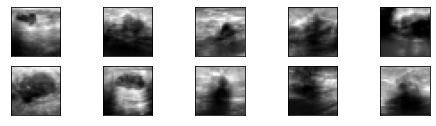

In [9]:
#B1
imshow_20(image_val_0,10)
print("10 images in validation dataset, class=0")

10 images in val dataset, class=1


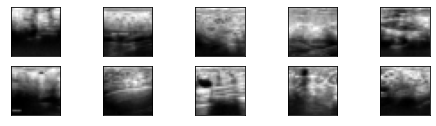

In [10]:
#B1
imshow_20(image_val_1,10)
print("10 images in val dataset, class=1")

10 images in test dataset, class=0


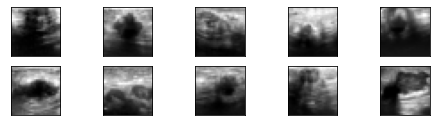

In [11]:
#B1
imshow_20(image_test_0,10)
print("10 images in test dataset, class=0")

10 images in test dataset, class=1


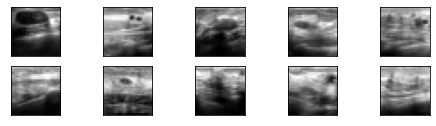

In [12]:
#B1
imshow_20(image_test_1,10)
print("10 images in test dataset, class=1")

# B2 Logistic regression [4 marks]

In [7]:
#B2 Logistic regression
#preprocess the dataset
#in order to use sklearn in nest part, we define a function transform dataset to array

def get_numpy(dataset):
    data_image_np=[]
    data_label_np=[]
    for image, label in dataset:
        data_image_np.append(image.squeeze().numpy())#squeeze the tensor and transform it to array
        data_label_np.append(label.squeeze())
    return np.array(data_image_np).reshape(-1,28*28),np.array(data_label_np)#reduce the dimention of image, make sue we can use sklearn


#use the function above precess the three dataset
train_image_np,train_label_np = get_numpy(train_dataset)
val_image_np,val_label_np = get_numpy(val_dataset)
test_image_np,test_label_np = get_numpy(test_dataset)

#combine the train and validation dataset, we will use this to do gridsearchcv
train_val_image_np=np.vstack((train_image_np,val_image_np))
train_val_label_np=np.hstack((train_label_np,val_label_np))

#check the dim of vectors
print(train_val_image_np.shape)
print(train_val_label_np.shape)
print(train_image_np.shape)
print(train_label_np.shape)
print(val_image_np.shape)
print(val_label_np.shape)
print(test_image_np.shape)
print(test_label_np.shape)

(624, 784)
(624,)
(546, 784)
(546,)
(78, 784)
(78,)
(156, 784)
(156,)


## B2(a) use sklearn

In [8]:
#B2
#part a, SKLEARN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

#define the regularisaton para
C=np.logspace(-1,3,base=10,num=5,dtype=float)

test_fold = np.zeros((np.shape(train_val_image_np)[0], 1))
#make sure the train dataset never set as validation
test_fold[0:np.shape(train_image_np)[0]] = -1
ps = PredefinedSplit(test_fold)

parameters={'C':C}
regression=LogisticRegression(solver='liblinear')

#use GridSearchCV to get the best param
clf = GridSearchCV(regression, parameters,cv=ps)
#fit the model
clf_result=clf.fit(train_val_image_np,train_val_label_np)
best_params=clf.best_params_

C=best_params['C']

regression_new=LogisticRegression(C=C,solver='liblinear')
regression_new.fit(train_image_np,train_label_np)

#predict the labels using best model
train_predict=regression_new.predict(train_image_np)
val_predict=regression_new.predict(val_image_np)
test_predict=regression_new.predict(test_image_np)

#get the accuracy score using the function in sklearn
m1_train=accuracy_score(train_label_np,train_predict)
m2_val=accuracy_score(val_label_np,val_predict)
m3_test=accuracy_score(test_label_np,test_predict)

#record the three score in part a
use_sklearn=[m1_train,m2_val,m3_test]

print(m1_train)
print(m2_val)
print(m3_test)
print(C)



0.9523809523809523
0.8846153846153846
0.7948717948717948
1.0


## B2(b) use pytorch

In [9]:
#Part B

import torch
import torch.nn.functional as F


In [10]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self):
        
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(28 * 28, 1)     
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
#def a function to get accuracy  
def get_accuracy(label_predeict,label_true):
    
    #we assume the output>0.5 means true
    for i in range(len(label_predeict)):
        if(label_predeict[i]<0.5):
            label_predeict[i]=0
        else:
            label_predeict[i]=1

    accuracy=(label_predeict.squeeze()==label_true).sum()/len(label_predeict)
    return accuracy


In [11]:
max_epoch=5
import torch.optim as optim

def get_model_torch(lamda):
    LR_model=LogisticRegression()
    criterion = torch.nn.BCELoss()
    optimizer = optim.SGD(LR_model.parameters(), lr=0.01,weight_decay=lamda, momentum=0.9)
    
    for epoch in range(max_epoch):

        LR_model.train()
        
        for i,data in enumerate(train_loader, 0):
            inputs, labels = data
            
            optimizer.zero_grad()
            #forward
            outputs = LR_model(inputs.view(-1,28*28)).squeeze()
            
            labels = labels.squeeze().float()
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()
            
        print('Loss: {:.6f}, epoch: {}, lamda: {} '.format(loss, epoch, lamda))

    return LR_model
    

In [12]:
#define a list to store param
lamda=[0.01,0.1,1,10]

best_C=lamda[0]
acc_old=0


for i in range(len(lamda)):
    #train the model on the train dataset
    LR_model=get_model_torch(lamda[i])

    label_val_predict=LR_model(torch.from_numpy(val_image_np)).squeeze().detach().numpy()
    #chose the best param on validation model
    acc=get_accuracy(label_val_predict,val_label_np)

    if(acc>acc_old):
        acc_old=acc
        best_C=lamda[i]

print(best_C)

Loss: 0.047924, epoch: 0, lamda: 0.01 
Loss: 0.618628, epoch: 1, lamda: 0.01 
Loss: 0.127341, epoch: 2, lamda: 0.01 
Loss: 0.133133, epoch: 3, lamda: 0.01 
Loss: 0.198488, epoch: 4, lamda: 0.01 
Loss: 0.481248, epoch: 0, lamda: 0.1 
Loss: 0.088703, epoch: 1, lamda: 0.1 
Loss: 0.391357, epoch: 2, lamda: 0.1 
Loss: 0.510815, epoch: 3, lamda: 0.1 
Loss: 1.045970, epoch: 4, lamda: 0.1 
Loss: 1.034101, epoch: 0, lamda: 1 
Loss: 0.036602, epoch: 1, lamda: 1 
Loss: 0.570904, epoch: 2, lamda: 1 
Loss: 0.582478, epoch: 3, lamda: 1 
Loss: 0.246185, epoch: 4, lamda: 1 
Loss: 0.948580, epoch: 0, lamda: 10 
Loss: 1.306681, epoch: 1, lamda: 10 
Loss: 1.440155, epoch: 2, lamda: 10 
Loss: 0.332165, epoch: 3, lamda: 10 
Loss: 0.443807, epoch: 4, lamda: 10 
0.01


In [13]:
#use the best param train model again
LR=get_model_torch(best_C)

label_train_predict=LR(torch.from_numpy(train_image_np)).detach().numpy()
label_val_predict=LR(torch.from_numpy(val_image_np)).detach().numpy()
label_test_predict=LR(torch.from_numpy(test_image_np)).detach().numpy()

#calculate the m1-m2
m1_nn=get_accuracy(label_train_predict,train_label_np)
m2_nn=get_accuracy(label_val_predict,val_label_np)
m3_nn=get_accuracy(label_test_predict,test_label_np)

use_nn=[m1_nn,m2_nn,m3_nn]

print(m1_nn)
print(m2_nn)
print(m3_nn)

Loss: 0.653630, epoch: 0, lamda: 0.01 
Loss: 0.378191, epoch: 1, lamda: 0.01 
Loss: 0.256944, epoch: 2, lamda: 0.01 
Loss: 0.141404, epoch: 3, lamda: 0.01 
Loss: 0.308828, epoch: 4, lamda: 0.01 
0.7893772893772893
0.8717948717948718
0.8012820512820513


# B3 Performance comparison (2 marks)

## B3(a) Summarise each of the three metrics from the two models in B2 using one or more bar graphs

[Text(0.125, 0, 'train'), Text(1.125, 0, 'valid'), Text(2.125, 0, 'test')]

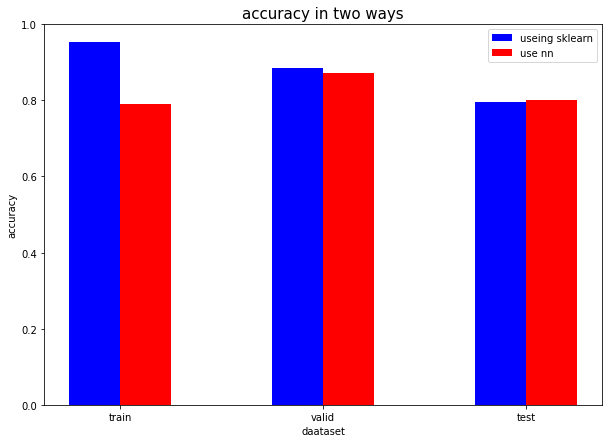

In [14]:
#B3(a)

labels=["train","valid","test"]

xticks=np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 7))

ax.bar(xticks, use_sklearn, width=0.25, label="useing sklearn", color="blue")

ax.bar(xticks + 0.25, use_nn, width=0.25, label="use nn", color="red")

ax.set_title("accuracy in two ways", fontsize=15)
ax.set_xlabel("daataset")
ax.set_ylabel("accuracy")
ax.legend()

ax.set_xticks(xticks+0.125 )
ax.set_xticklabels(labels)

## B3(b) Describe at least two observations interesting to you. [1 mark]

### (1). I find it is interesting if we use pytorch nn to dothis, the bigger of epoch, the better the accuracy.

### (2). Using pytorch nn, the accuracy lower than using sklearn on train an validation set, but higher on test.

### (3). the accuracy on train and validation dataset are hinger than on test set

# C. Convolutional Neural Networks on OCTMNIST [8 marks]

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

## C1 Data loading and inspection [2 mark]

In [16]:
#part C
#C1
data_flag_C = 'octmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag_C]
task = info['task']
n_channels_C = info['n_channels']
n_classes_C = len(info['label'])

DataClass_C = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset_C = DataClass_C(root='./data',split='train', transform=data_transform, download=download)
val_dataset_C = DataClass_C(root='./data',split='val', transform=data_transform, download=download)
test_dataset_C = DataClass_C(root='./data',split='test', transform=data_transform, download=download)

train_loader_C = data.DataLoader(train_dataset_C, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_C = data.DataLoader(val_dataset_C, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader_C = data.DataLoader(test_dataset_C, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



Using downloaded and verified file: ./data\octmnist.npz
Using downloaded and verified file: ./data\octmnist.npz
Using downloaded and verified file: ./data\octmnist.npz


In [17]:
#C1
#def a function to classfiy the data in to different class
def classify_c(dataset):
    images_0=[]
    images_1=[]
    images_2=[]
    images_3=[]
    for data in dataset:
        image , label = data
        if label==0:
            images_0.append(image.squeeze().numpy())#transform tensor to array
        elif label==1:
            images_1.append(image.squeeze().numpy())#transform tensor to array
        elif label==2:
            images_2.append(image.squeeze().numpy())#transform tensor to array
        else:
            images_3.append(image.squeeze().numpy())#transform tensor to array

    return images_0,images_1,images_2,images_3

#now we have data in 4 classes
train_img_0,train_img_1,train_img_2,train_img_3=classify_c(train_dataset_C)
train_img=[train_img_0,train_img_1,train_img_2,train_img_3]


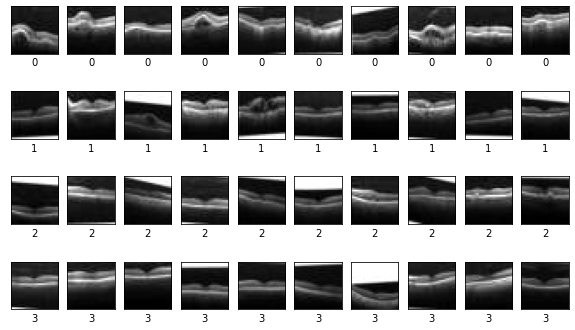

In [18]:
#C1
#use a two layer for loop, plot 40 pctures, every line is a class 
plt.figure(figsize=(10,6))
for k in range(4):
    for i in range(10):
        plt.subplot(4, 10, i + 1+k*10)
        plt.imshow(train_img[k][i], cmap='gray')
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(k)#sign the label behind the pictures

## C2 Convolutional neural networks [4 marks]

### C2(a) Design a CNN with two Conv layers and two FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 [2 marks]

In [25]:
#PART C2(a)
#defein a 2d CNN
class CNN2(nn.Module):
    
    #use __init__function make it easy to change the model
    def __init__(self,channel_1,channel_2,padding_1,padding_2,ker_1,ker_2,fc_size):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, channel_1, ker_1, padding=padding_1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(channel_1, channel_2, ker_2, padding=padding_2)

        size=int(((28+(2*padding_1)-ker_1+1)/2+(2*padding_2)-ker_2+1)/2)
        # print(size)

        fc_para=channel_2 * size * size

        self.fc1 = nn.Linear(fc_para, fc_size)
        self.fc2 = nn.Linear(fc_size, 4)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = self.pool(x)

        x = F.relu(self.conv2(x))

        x = self.pool(x)
        # print(len(x[0]))
        # print(len(x[0][0]))
        # print(len(x[0][0][0]))
       
        x = x.view(-1,len(x[0])*len(x[0][0])*len(x[0][0][0]))

        x = self.fc1(x)
        x = self.fc2(x)
        return x


### C2(b) Design a CNN with three Conv layers and three FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 [2 marks]


In [26]:
#PART C2(b)
#design 3d CNN model
class CNN3(nn.Module):

    #use __init__function make it easy to change the model
    def __init__(self,channel_1,channel_2,channel_3,ker_1,ker_2,ker_3,fc_size_1,fc_size_2):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, channel_1, ker_1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(channel_1, channel_2, ker_2)
        self.conv3 = nn.Conv2d(channel_2, channel_3, ker_3)

        size=int(((28+-ker_1+1)/2-ker_2+1)/2-ker_3+1)

        fc_para=channel_3 * size * size#caculate the param in fc lyer

        
        self.fc1 = nn.Linear(fc_para, fc_size_1)
        self.fc2 = nn.Linear(fc_size_1, fc_size_2)
        self.fc3 = nn.Linear(fc_size_2, 4)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
       
        x = x.view(-1,len(x[0])*len(x[0][0])*len(x[0][0][0]))

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [27]:
#def a function to get accuracy
#this function learn from lab7

def get_accuracy_C(data_loader,model):
    correct=0
    total=0
    with torch.no_grad(): 
        for data in data_loader:
            images,labels=data

            outputs=model(images)
            _, predicted = torch.max(outputs.data,1)#get the predict value and index, we just neeed index

            total+=labels.size(0)
            correct+=(predicted==labels.squeeze()).sum().item()

    accuracy=correct/total

    return accuracy

In [28]:
#def a funtion to train model

def train_CNN(model,max_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(max_epochs): 
        running_loss=0.0
        for i,data in enumerate(train_loader_C, 0):

            inputs, labels = data

            labels=labels.squeeze().long()

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training!')

In [29]:
import time
#chose the best model in inputs model, and record train time, return the best model train time


def get_best_CNN(CNN_list):
    best_acc=0
    CNN_index=0
    time_list=[]
    for i in range(3):
        #record the train time
        time_start=time.time()
        train_CNN(CNN_list[i],6)#train the model in the trainset
        time_end=time.time()
        time_list.append(time_end-time_start)
        
        acc=get_accuracy_C(val_loader_C,CNN_list[i])#calculate the accuracy in the validation set

        print(acc)

        if(best_acc<acc):
            best_acc=acc
            CNN_index=i#get the highest accuracy in val_dataset, chose this as best
            
        print(CNN_index)

    return CNN_index, time_list


In [30]:
#we use different value to define 3 different CNN
CNN_2_A=CNN2(6,16,0,0,5,3,64)
CNN_2_B=CNN2(8,32,2,2,7,3,128)
CNN_2_C=CNN2(6,16,2,2,5,5,32)

CNN_list=[CNN_2_A,CNN_2_B,CNN_2_C]

In [31]:
best_CNN2,time_2d=get_best_CNN(CNN_list)

[1,  2000] loss: 1.149
[2,  2000] loss: 0.942
[3,  2000] loss: 0.698
[4,  2000] loss: 0.618
[5,  2000] loss: 0.570
[6,  2000] loss: 0.537
Finished Training!
0.8265324963072378
0
[1,  2000] loss: 1.067
[2,  2000] loss: 0.768
[3,  2000] loss: 0.660
[4,  2000] loss: 0.582
[5,  2000] loss: 0.542
[6,  2000] loss: 0.510
Finished Training!
0.8185007385524372
0
[1,  2000] loss: 1.145
[2,  2000] loss: 0.828
[3,  2000] loss: 0.629
[4,  2000] loss: 0.556
[5,  2000] loss: 0.518
[6,  2000] loss: 0.492
Finished Training!
0.8329948301329394
2


In [32]:
#use the best model get M1-M4
model=CNN_list[best_CNN2]

train_accuracy=get_accuracy_C(train_loader_C,model)
val_accuracy=get_accuracy_C(val_loader_C,model)
test_accuracy=get_accuracy_C(test_loader_C,model)
train_time_2d=time_2d[best_CNN2]

value_2d=[train_accuracy,val_accuracy,test_accuracy]

print(train_accuracy)
print(val_accuracy)
print(test_accuracy)
print(train_time_2d)

0.8313550888927644
0.8329948301329394
0.63
255.15946316719055


In [33]:
#we use different value to define 3 different CNN
CNN_3_A=CNN3(6,16,32,7,5,3,120,64)
CNN_3_B=CNN3(8,32,48,5,3,3,168,80)
CNN_3_C=CNN3(10,48,80,3,3,3,120,64)

CNN3_list=[CNN_3_A,CNN_3_B,CNN_3_C]

In [34]:
best_CNN3,time_3d=get_best_CNN(CNN3_list)

[1,  2000] loss: 1.168
[2,  2000] loss: 1.156
[3,  2000] loss: 0.983
[4,  2000] loss: 0.704
[5,  2000] loss: 0.632
[6,  2000] loss: 0.579
Finished Training!
0.8066838995568686
0
[1,  2000] loss: 1.158
[2,  2000] loss: 0.839
[3,  2000] loss: 0.701
[4,  2000] loss: 0.653
[5,  2000] loss: 0.581
[6,  2000] loss: 0.526
Finished Training!
0.8298559822747416
1
[1,  2000] loss: 1.163
[2,  2000] loss: 0.923
[3,  2000] loss: 0.696
[4,  2000] loss: 0.638
[5,  2000] loss: 0.546
[6,  2000] loss: 0.495
Finished Training!
0.8319793205317577
2


In [35]:
#use the best model get M1-M4
model=CNN3_list[best_CNN3]

train_accuracy=get_accuracy_C(train_loader_C,model)
val_accuracy=get_accuracy_C(val_loader_C,model)
test_accuracy=get_accuracy_C(test_loader_C,model)
train_time_3d=time_3d[best_CNN3]

value_3d=[train_accuracy,val_accuracy,test_accuracy]

print(train_accuracy)
print(val_accuracy)
print(test_accuracy)
print(train_time_3d)

0.831806477425444
0.8319793205317577
0.645
392.24672842025757


## C3 Performance comparison (2 marks)

### C3(c) Summarise each of the four metrics from the two models in B2 using one or more bar graphs. [1 mark]

[Text(0.125, 0, 'train'), Text(1.125, 0, 'valid'), Text(2.125, 0, 'test')]

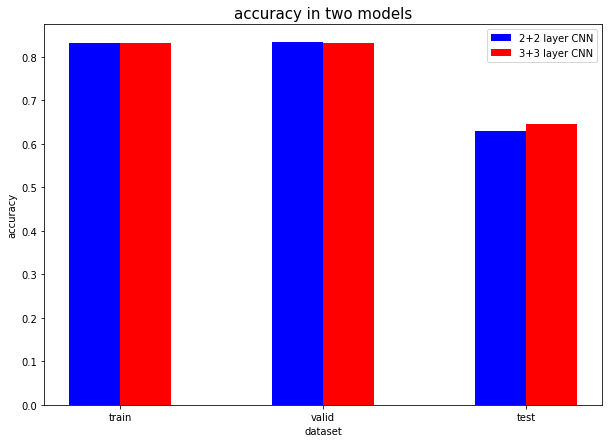

In [36]:
#C3(c)
#plot the m1-m3 in 2 models
labels=["train","valid","test"]

xticks=np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 7))

ax.bar(xticks, value_2d, width=0.25, label="2+2 layer CNN", color="blue")
ax.bar(xticks + 0.25, value_3d, width=0.25, label="3+3 layer CNN", color="red")

ax.set_title("accuracy in two models", fontsize=15)
ax.set_xlabel("dataset")
ax.set_ylabel("accuracy")
ax.legend()

# adjust the xocation of x_label
ax.set_xticks(xticks+0.125 )
ax.set_xticklabels(labels)

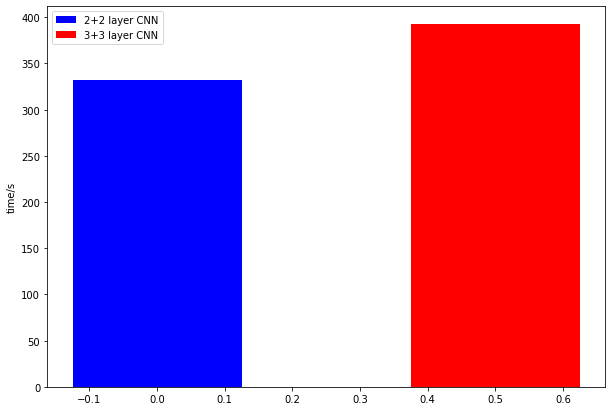

In [37]:
#C3(c)
#plot train_time
xticks=np.arange(1)

fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(xticks, time_2d, width=0.25, label="2+2 layer CNN", color="blue")

ax.bar(xticks + 0.5, time_3d, width=0.25, label="3+3 layer CNN", color="red")
ax.set_ylabel("time/s")
ax.legend()

### C3(d) Describe at least two observations interesting to you. [1 mark]

### (1). 3+3 layer CNN have better accuracy on testset

### (2). 3+# layer CNN need more time to train tahn 2+2 layer CNN

### (3). if we use more epoch to train the model, we will get better accuracy, but we need lots of time to train

# D. Unsupervised learning on Fashion-MNIST [8 marks]

Choose any two out of the 10 classes and use only the test data for these two chosen classes to complete tasks in this section.

In [62]:
#part D
import torchvision

#precess data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[.5], std=[.5])])

#because we just need test data in this section, so we just get the test data and process test data, set it as train
#download and load the data

fashion_train_dataset_unpre=torchvision.datasets.FashionMNIST(root='./data', train = False, download = True ,transform=transform)

fashion_train_loader_all=torch.utils.data.DataLoader(fashion_train_dataset_unpre, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

fashion_train_dataset=[]
fashion_test_dataset=[]


In [40]:
#pre process the data, transform to array, make it easy for us to use sklearn

fashion_train_dataset_images=[]
fashion_train_dataset_labels=[]
fashion_test_dataset=[]

#define two list to store two class data
fashion_train_image_6=[]
fashion_train_image_9=[]

i=0

for data in fashion_train_dataset_unpre:

    image,label=data
    
    #chose the data in class7 and class9 
    if label==6 or label==9:
        fashion_train_dataset_images.append(image.squeeze().numpy())
        fashion_train_dataset_labels.append(label)

#get the data in 2 class
for data in fashion_train_dataset_unpre:
    
    image,label=data   
    if label==6:
        fashion_train_image_6.append(image.squeeze().numpy())

    if label==9:
        fashion_train_image_9.append(image.squeeze().numpy())



In [41]:
#transform to array to easy to use
fashion_train_dataset_images=np.array(fashion_train_dataset_images)
fashion_train_dataset_labels=np.array(fashion_train_dataset_labels)

fashion_train_image_6=np.array(fashion_train_image_6)
fashion_train_image_9=np.array(fashion_train_image_9)


In [42]:
#check the data
fashion_train_dataset_images.shape
fashion_train_dataset_images.reshape(-1,28*28).shape

print(fashion_train_image_6.shape)
print(fashion_train_image_9.shape)

(1000, 28, 28)
(1000, 28, 28)


In [43]:
fashion_train_dataset_images=np.array(fashion_train_dataset_images)

## D1. Dimensionality reduction and clustering [7 marks]

### D1(a) Apply PCA to all images of these two chosen classes. Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first). [1 marks]

In [44]:
#(a)
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(fashion_train_dataset_images.reshape(-1,28*28))

PCA()

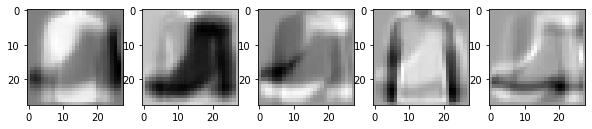

In [45]:
eigenvector=pca.components_.reshape(-1,28,28)

plt.figure(figsize=(10,10))
# plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(eigenvector[i], cmap='gray')



### D1(b) Use the top 30 PCs to reconstruct 10 images, with 5 from each class (any 5 images are fine from each class). Show these 10 pairs of reconstructed and original images. [1 marks]

In [46]:
#(b)
#PCA, top 30 PCs
pca_30 = PCA(n_components=30)
pca_30.fit(fashion_train_dataset_images.reshape(-1,28*28))

PCA(n_components=30)

In [47]:
fashion_train_dataset_images.shape

(2000, 28, 28)

5 pair in class 6


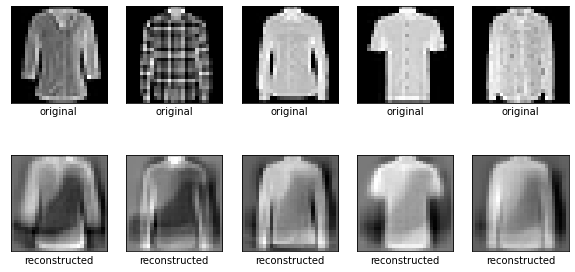

In [48]:
#now we plot 5 pairs reconstructed and original images in class 6

plt.figure(figsize=(10,5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(fashion_train_image_6[i], cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.xlabel('original')

outputs=pca_30.transform(fashion_train_image_6.reshape(-1,28*28))

X_reconst = np.dot(outputs, pca_30.components_)

for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_reconst[i].reshape(28,28),cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.xlabel('reconstructed')
print('5 pair in class 6')


5 pair in class 9


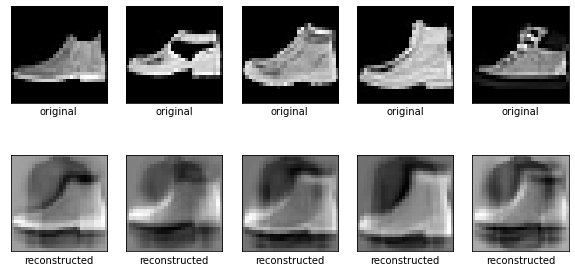

In [49]:
#now we plot 5 pairs reconstructed and original images in class 9
plt.figure(figsize=(10,5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(fashion_train_image_9[i], cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.xlabel('original')

outputs=pca_30.transform(fashion_train_image_9.reshape(-1,28*28))

X_reconst = np.dot(outputs, pca_30.components_)

for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_reconst[i].reshape(28,28),cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.xlabel('reconstructed')
print('5 pair in class 9')


### D1(c) Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. using the top two PCs). Use different colours/markers for the two classes for better visualisation (Hint: You need to use the class labels here for visualisation). [1 marks]

In [50]:
#use pca to reduce dim
fashion_all=np.vstack([fashion_train_image_6,fashion_train_image_9])#combine 2 classes data, make it easy for us to label later
print(fashion_all.shape)

#reduce to 2d
pca_2d=PCA(n_components=2)
pca_2d.fit(fashion_all.reshape(-1,28*28))

#reduce to 2d
class_all = pca_2d.transform(fashion_all.reshape(-1,28*28))
print(class_all.shape)

#2d data in two class
fashion_all_6=class_all[:1000]
fashion_all_9=class_all[1000:]

(2000, 28, 28)
(2000, 2)


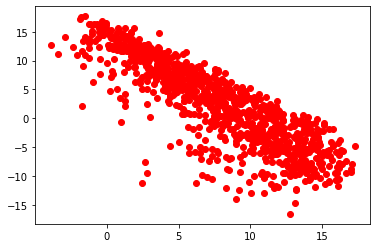

In [51]:
#data plot in class 6
plt.scatter(x=fashion_all_6.T[0] , y=fashion_all_6.T[1],c='red')

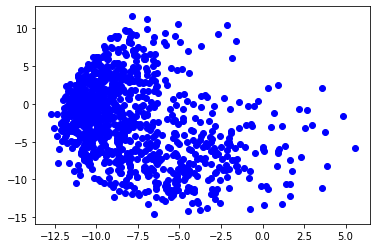

In [52]:
#data plot in class 9
plt.scatter(x=fashion_all_9.T[0] , y=fashion_all_9.T[1],c='blue')

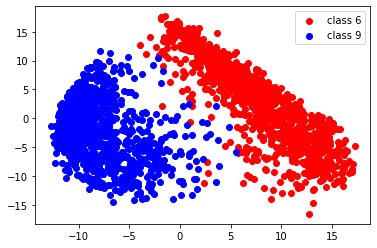

In [53]:
#plot them in one figure
plt.scatter(x=fashion_all_6.T[0] , y=fashion_all_6.T[1],c='red',label="class 6")
plt.scatter(x=fashion_all_9.T[0] , y=fashion_all_9.T[1],c='blue',label="class 9")
plt.legend()

### D1(d) Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers in 2D. [2 marks].

In [54]:
#(d)
#using SpectralClustering

from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=2 , assign_labels='discretize', random_state=0)
clustering.fit(class_all)
pred_label=clustering.fit_predict(class_all)#get a label list with 0,1

In [55]:
index_0=pred_label==0#we can use this label list as indx
index_1=pred_label==1
pred_0=class_all[index_0]
pred_1=class_all[index_1]

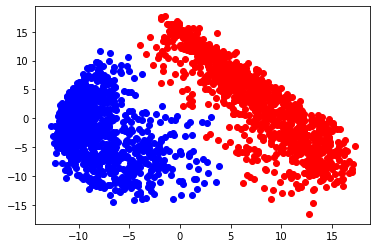

In [56]:
#plot the data after SpectralClustering
plt.scatter(pred_0.T[0] , y=pred_0.T[1],c='blue')
plt.scatter(pred_1.T[0] , y=pred_1.T[1],c='red')

### D1(e) Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. You are free to choose the activation functions and settings such as stride and padding. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the loss against the epoch. [2 marks]

In [57]:
#D1(e)
#design a Autoencoder, which is learn from lab 8
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 6, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(6, 24, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 30, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(30, 44, 3),
            nn.ReLU(),
            nn.Conv2d(44, 64, 3)
            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 44, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(44, 30, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(30, 24, 5, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 6, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [58]:
myAE=Autoencoder()

#information of model
params = list(myAE.parameters())
print(len(params))
print(params[0].size())  # First Conv2d's .weight
print(params[1].size())  # First Conv2d's .bias
print(params[1])

20
torch.Size([6, 1, 3, 3])
torch.Size([6])
Parameter containing:
tensor([-0.1185,  0.1006, -0.2867,  0.2513, -0.3082,  0.1231],
       requires_grad=True)


In [59]:
#chose the data let labels==6 or 9
fashion_train_loader=[]
for data in fashion_train_dataset_unpre:

    image,label=data
    
    #chose the data in class6 and class9 
    if label==6 or label==9:
        fashion_train_loader.append(data)

In [60]:
#Training (optimisation) parameters
batch_size=64
learning_rate=0.001
max_epochs = 20

#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_rate, weight_decay=1e-5)
#Specify how the data will be loaded in batches (with random shuffling)
fashion_train_loader = torch.utils.data.DataLoader(fashion_train_loader, batch_size=batch_size, shuffle=True)

#Storage
outputs = []
loss_list=[]

#Start training
for epoch in range(max_epochs):
    for data in fashion_train_loader:
        img, label = data
        optimizer.zero_grad()
        recon = myAE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()  
                  
    loss_list.append(float(loss))
    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)

Epoch:1, Loss:0.9012
Epoch:2, Loss:0.8890
Epoch:3, Loss:0.8729
Epoch:4, Loss:0.8530
Epoch:5, Loss:0.8498
Epoch:6, Loss:0.8651
Epoch:7, Loss:0.6665
Epoch:8, Loss:0.7049
Epoch:9, Loss:0.7071
Epoch:10, Loss:0.6554
Epoch:11, Loss:0.6291
Epoch:12, Loss:0.6084
Epoch:13, Loss:0.6058
Epoch:14, Loss:0.6336
Epoch:15, Loss:0.6429
Epoch:16, Loss:0.5779
Epoch:17, Loss:0.5819
Epoch:18, Loss:0.6327
Epoch:19, Loss:0.6635
Epoch:20, Loss:0.6391


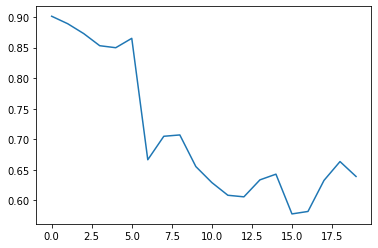

In [61]:
#plot the loos against epoch
epoch_list=range(max_epochs)
plt.plot(epoch_list,loss_list)

### D2 Observation, Describe at least two observations interesting to you from D1 above.

### (1). I have chosen different pairs classes in this section, I find if two classes are similar.

### (2). It is interesting that eigenvectord are looking like the overlap of two class.